# Climate Change Belief Analysis 2022


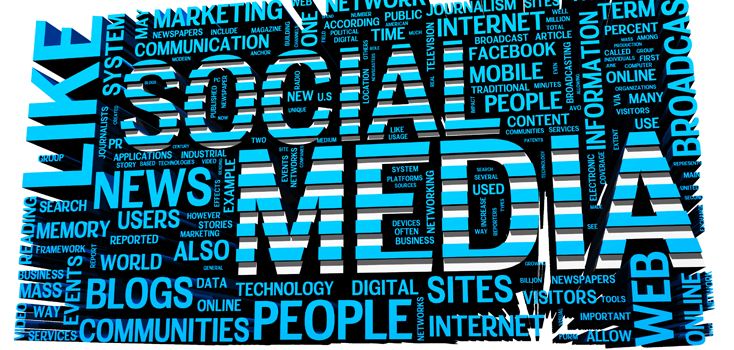

### About the problem

Many companies are built around lessening one’s environmental impact or carbon footprint. They     offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.
                
### The Objective

Create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.


Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


                
   
                
                
            


<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Data Cleaning</a>

<a href=#three>4. Exploratory Data Analysis (EDA)</a>

<a href=#four>5. Data Engineering</a>

<a href=#five>6. Modeling</a>

<a href=#six>7. Model Performance</a>

<a href=#seven>8. Model Explanations</a>

<a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>



In [1]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import re    
import nltk  
import string
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# Libraries for data preparation and model building
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



/home/lion/.local/lib/python3.9/site-packages/pandas/compat/_optional.py:149: UserWarning: Pandas requires version '1.3.1' or newer of 'bottleneck' (version '1.2.1' currently installed).
  warnings.warn(msg, UserWarning)


<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [2]:
#Load the train data
df_train = pd.read_csv('train.csv')
df_train.head()

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [ ]:
#Load the test data
df_test = pd.read_csv('test.csv')
df_test.head()

In [ ]:
#Load submission data
sub = pd.read_csv('sample_submission.csv')
sub.head()

In [ ]:
#Checking number of rows in train dataset
df_train.shape

The train dataset contains 15819 observations and 3 columns

In [ ]:
#Basic info about the data
df_train.info()

Comparing with the number of observations, the dataset has no null entries

In [ ]:
train = df_train.copy()

In [ ]:
test = df_test.copy()

<a id="three"></a>
## 3. Data Cleaning
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [ ]:
#Converting the message to lowercase
train["message_lower"] = train["message"].str.lower()
train.head()

In [ ]:
test["message_lower"] = test["message"].str.lower()
test.head()

In [ ]:
#Removing any link in the message
def remove_links(col):
    
    col = re.sub(r'http\S+', '', col) # remove http links
    col = re.sub(r'bit.ly/\S+', '', col) # remove bitly links
    col = re.sub(r'https\S+', '', col) # remove http links
    #col = col.strip('[link]') # remove [links]
    return col

In [ ]:
train["link_less"] = train['message_lower'].apply(lambda x : remove_links(x))
train.head()

In [ ]:
#Dropping the message_lower column
train.drop('message_lower',axis=1,inplace = True)

In [ ]:
test["link_less"] = test['message_lower'].apply(lambda x : remove_links(x))

In [ ]:
test.drop('message_lower',axis=1,inplace = True)

In [ ]:
#Removes retweets and tweeted at
def remove_users(col):

    col = re.sub('(rt\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', col) # remove retweet
    col = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', col) # remove tweeted at
    return col

In [ ]:
train["tweeps"] = train['link_less'].apply(lambda x : remove_users(x))
train.head()

In [ ]:
#Dropping the message_lower column
train.drop('link_less',axis=1,inplace = True)

In [ ]:
test["tweeps"] = test['link_less'].apply(lambda x : remove_users(x))

In [ ]:
test.drop('link_less',axis=1,inplace = True)

In [ ]:
#Removing punctuations
def remove_punctuation(text):
    
    return text.translate(str.maketrans('', '', string.punctuation))


In [ ]:
train["clean_tweet"] = train['tweeps'].apply(lambda x : remove_punctuation(x))
train.head()

In [ ]:
train.drop('tweeps',axis=1,inplace = True)

In [ ]:
test["clean_tweet"] = test['tweeps'].apply(lambda x : remove_punctuation(x))


In [ ]:
test.drop('tweeps',axis=1,inplace = True)
test.head()

<a id="four"></a>
## 4. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [ ]:
#Checking the distribution of the target variable
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

In [ ]:
#Grouping by sentiment analysis
temp = train.groupby('sentiment').count()['tweetid'].reset_index().sort_values(by='tweetid',ascending=False)
temp.style.background_gradient(cmap='Purples')

In [ ]:
#A funnel chart showing the distribution of the target variable
fig = go.Figure(go.Funnelarea(
    text = temp.sentiment,
    values = temp.tweetid,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

The target variable has four classes.
The variable is also imbalanced with class 1 being the majority class and class -1 being the minority class

#### Tokenization

In [ ]:
def tokenization(text):
    new_text = text.strip()
    new_text = re.split('\W+', text)
    return new_text

train['tokens'] = train['clean_tweet'].apply(lambda x: tokenization(x))
test['tokens'] = test['clean_tweet'].apply(lambda x: tokenization(x))
train.head()

#### Removing Stopwords

In [ ]:
stopword = nltk.corpus.stopwords.words('english')


In [ ]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
train['no_stopword'] = train['tokens'].apply(lambda x: remove_stopwords(x))
test['no_stopword'] = test['tokens'].apply(lambda x: remove_stopwords(x))


### Most Common Words 

#### Creating a wordcloud of the tweets 

In [ ]:
# creating the text variable
def gen_text(col):
    text = ' '.join(col)
    return text
    
train['gen_text'] = train['no_stopword'].apply(lambda x: gen_text(x))
text = " ".join(title for title in train['gen_text'])

# Creating word_cloud with text as argument in .generate() method

word_cloud1 = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud

plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Most common words in our text
top = Counter([item for sublist in train['no_stopword'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree Of Most Common Words')
fig.show()

From the wordcloud and treemap the words climate,change,a,global and  warming are the most repeated words.
The words says,like,fight are the least used words in the top 25 most used words 

### Most Common Words In Each Sentiment

In [ ]:
class_one = train[train['sentiment']== 1]
class_two= train[train['sentiment']== 2]
class_zero = train[train['sentiment']== 0]
class_neg = train[train['sentiment']== -1]

In [ ]:
#Class_one
def gen_text(col):
    text = ' '.join(col)
    return text
    
class_one['gen_text'] = class_one['no_stopword'].apply(lambda x: gen_text(x))
text = " ".join(title for title in class_one['gen_text'])

# Creating word_cloud with text as argument in .generate() method

word_cloud1 = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud

plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Most common words in class_one
top = Counter([item for sublist in class_one['no_stopword'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree Of Most Common Words in class one')
fig.show()

From the wordcloud and treemap the words climate,change,a,global and warming are the most repeated words. The words new,like,fight,hoax are the least used words in the top 25 most used words 

In [ ]:
#Class_two
def gen_text(col):
    text = ' '.join(col)
    return text
    
class_two['gen_text'] = class_two['no_stopword'].apply(lambda x: gen_text(x))
text = " ".join(title for title in class_two['gen_text'])

# Creating word_cloud with text as argument in .generate() method

word_cloud1 = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud

plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Most common words in class_two
top = Counter([item for sublist in class_two['no_stopword'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree Of Most Common Words in class two')
fig.show()

From the wordcloud and treemap the words climate,change,Trump,global and warming are the most repeated words. The words pruitt,president,chief,could are the least used words in the tweets

In [ ]:
#Class_zero
def gen_text(col):
    text = ' '.join(col)
    return text
    
class_zero['gen_text'] = class_zero['no_stopword'].apply(lambda x: gen_text(x))
text = " ".join(title for title in class_zero['gen_text'])

# Creating word_cloud with text as argument in .generate() method

word_cloud1 = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud

plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Most common words in class_zero
top = Counter([item for sublist in class_zero['no_stopword'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree Of Most Common Words in class zero')
fig.show()

From the wordcloud and treemap the words climate,change,global and warming are the most repeated words. The words hot,know,one are the least used words in the top 25 most used words 

In [ ]:
#Class_neg
def gen_text(col):
    text = ' '.join(col)
    return text
    
class_neg['gen_text'] = class_neg['no_stopword'].apply(lambda x: gen_text(x))
text = " ".join(title for title in class_neg['gen_text'])

# Creating word_cloud with text as argument in .generate() method

word_cloud1 = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud

plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Most common words in class_neg
top = Counter([item for sublist in class_neg['no_stopword'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree Of Most Common Words in class neg')
fig.show()

From the wordcloud and treemap the words climate,change,global and warming are the most repeated words. The words like,gore,obama are the least used words in the top 25 most used words

### N-Gram Analysis

#### Full Data Bi-gram analysis

In [ ]:
def generate_N_grams(text,ngram=2):
        temp=zip(*[text[i:] for i in range(0,ngram)])
        ans=[' '.join(ngram) for ngram in temp]
        return ans

In [ ]:
from collections import defaultdict
mydict = defaultdict(int)


In [ ]:
for text in train['no_stopword']:
    for word in generate_N_grams(text):
        mydict[word]+=1

In [ ]:
bigram_df =pd.DataFrame(sorted(mydict.items(),key=lambda x:x[1],reverse=True))

In [ ]:
fig = go.Figure(go.Bar(
            x=bigram_df.loc[0:25,1],
            y=bigram_df.loc[0:25,0],
            orientation='h'))

fig.show()

#### Full Data Trigram Anlysis

In [ ]:
mydict1 = defaultdict(int)

In [ ]:
for text in train['no_stopword']:
    for word in generate_N_grams(text,3):
        mydict1[word]+=1

In [ ]:
trigram_df =pd.DataFrame(sorted(mydict1.items(),key=lambda x:x[1],reverse=True))

In [ ]:
fig = go.Figure(go.Bar(
            x=trigram_df.loc[0:25,1],
            y=trigram_df.loc[0:25,0],
            orientation='h'))

fig.show()

<a id="five"></a>
## 5. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [ ]:
## Number of words in the text ##
train["num_words"] = train["message"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["message"].apply(lambda x: len(str(x).split()))


In [ ]:
## Number of unique words in the text ##
train["num_unique_words"] = train["message"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["message"].apply(lambda x: len(set(str(x).split())))


In [ ]:
## Number of characters in the text ##
train["num_chars"] = train["message"].apply(lambda x: len(str(x)))
test["num_chars"] = test["message"].apply(lambda x: len(str(x)))


In [ ]:
## Number of stopwords in the text ##
train["num_stopwords"] = train["message"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword]))
test["num_stopwords"] = test["message"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword]))

In [ ]:
## Number of punctuations in the text ##
train["num_punctuations"] =train['message'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['message'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

In [ ]:
## Number of title case words in the text ##
train["num_words_upper"] = train["message"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["message"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

In [ ]:
## Number of title case words in the text ##
train["num_words_title"] = train["message"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["message"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

In [ ]:
## Average length of the words in the text ##
train["mean_word_len"] = train["message"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["message"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#### Stemming

In [ ]:
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text



In [ ]:
train["text_stemmed"] = train["no_stopword"].apply(lambda text: stemming(text))
test["text_stemmed"] = test["no_stopword"].apply(lambda text: stemming(text))


#### Lemmatization

In [ ]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

In [ ]:
train['text_lemmatized'] = train['no_stopword'].apply(lambda x: lemmatizer(x))
test['text_lemmatized'] = test['no_stopword'].apply(lambda x: lemmatizer(x))

##### Data Splitting

In [ ]:
stem_df = train.drop(columns = ['sentiment','message','tweetid','clean_tweet','tokens','no_stopword','gen_text',
                               'text_lemmatized'])

In [ ]:
stem_test = test.drop(columns = ['message','tweetid','clean_tweet','tokens','no_stopword',
                               'text_lemmatized'])

In [ ]:
lemma_df = train.drop(columns = ['sentiment','message','tweetid','clean_tweet','tokens','no_stopword','gen_text',
                               'text_stemmed'])

In [ ]:
lemma_test = test.drop(columns = ['message','tweetid','clean_tweet','tokens','no_stopword',
                               'text_stemmed'])

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

In [ ]:
# label encode the target variable
y = LabelEncoder().fit_transform(train['sentiment'])

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(stem_df, y)


#### Vectorization

In [ ]:
# Get the tfidf vectors #
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(3,3))

In [ ]:
stem_df.head()

In [ ]:
stem_tf = tfidf_vec.fit_transform(stem_df['text_stemmed'])
stem_tf

<a id="six"></a>
## 6. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="seven"></a>
## 7. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="eight"></a>
## 8. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>